# SHAP Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import shap

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from shap_utils import *
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_shap = config["path_shap"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## SHAP Explainability

In [4]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTTurk

#### Inference on Full Text

In [5]:
# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
# predict_parameter_set_ttc4900 = {
#     'model': bert_model_ttc4900,
#     'tokenizer': bert_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': bert_model_tr_news,
#     'tokenizer': bert_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': bert_model_interpress,
#     'tokenizer': bert_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': bert_model_tc32,
#     'tokenizer': bert_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# bert_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, bert_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# bert_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, bert_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# bert_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, bert_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# bert_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, bert_label2id_tc32)

# path_classification_results = "Data/Classification_Results/BERTTurk/"

# with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tr_news, file)

# with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_interpress, file)

# with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tc32, file)

In [7]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [8]:
num_samples = 50

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [9]:
shap_explainer_ttc4900 = shap.Explainer(bert_pipeline_text_ttc4900)
ttc4900_bert_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_bert", 
                                                    shap_explainer_ttc4900, 
                                                    bert_full_text_preds_ttc4900, len(bert_label2id_ttc4900),
                                                    only_load=only_load)

    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, bert_tokenizer_ttc4900, threshold)
    
    shap_values_ttc_short, _ = apply_shap(path_shap, top_tokens_ttc4900, 
                                          f"shap_values_ttc_short_{threshold}_bert", 
                                          shap_explainer_ttc4900,
                                          bert_full_text_preds_ttc4900, len(bert_label2id_ttc4900),
                                          only_load=only_load)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (shap_values_ttc, shap_values_ttc_short, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_ttc_0.5_bert' file shape: (50, None, 7)
'shap_values_ttc_short_0.5_bert' file shape: (50, None, 7)


'shap_values_ttc_0.6_bert' file shape: (50, None, 7)
'shap_values_ttc_short_0.6_bert' file shape: (50, None, 7)


'shap_values_ttc_0.7_bert' file shape: (50, None, 7)
'shap_values_ttc_short_0.7_bert' file shape: (50, None, 7)


In [10]:
# sample_no = 4

# shap.plots.text(ttc4900_bert_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_bert_results[0.7][1][sample_no])


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.942
Overall Relative Change (ORC) positive changes      :  8.416 %
Overall Relative Change (ORC) negative changes      : -4.97 %


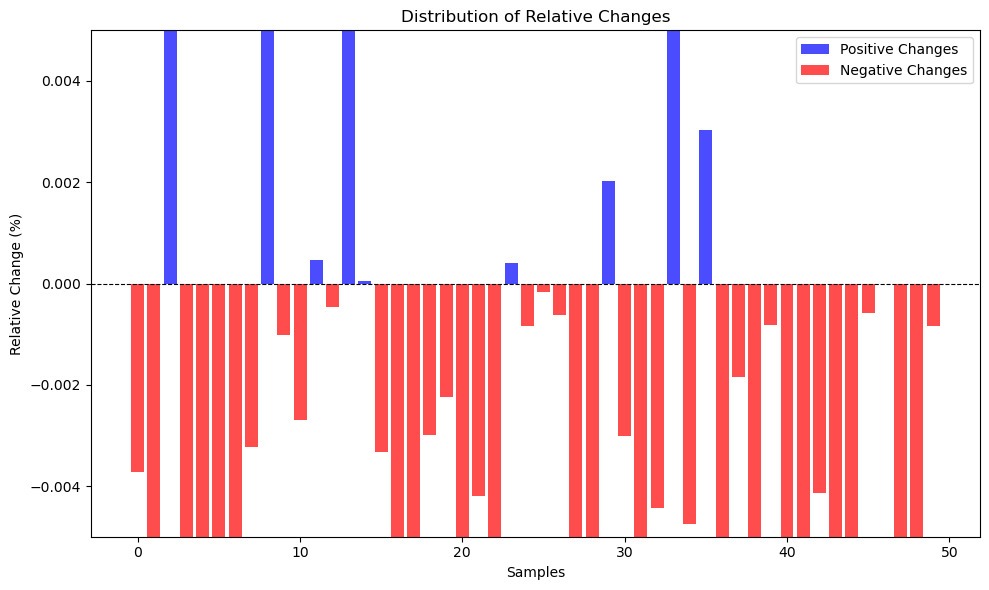


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.942
Overall Relative Change (ORC) positive changes      :  6.888 %
Overall Relative Change (ORC) negative changes      : -5.205 %


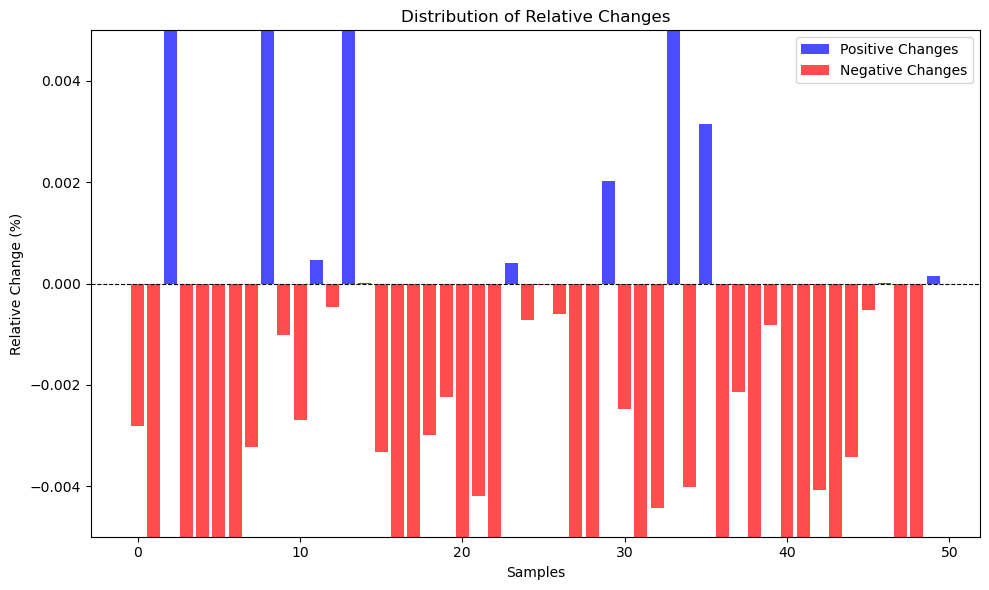


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.967
Explanations Contribution Score (ECS) of Top Tokens :  0.944
Overall Relative Change (ORC) positive changes      :  6.317 %
Overall Relative Change (ORC) negative changes      : -5.101 %


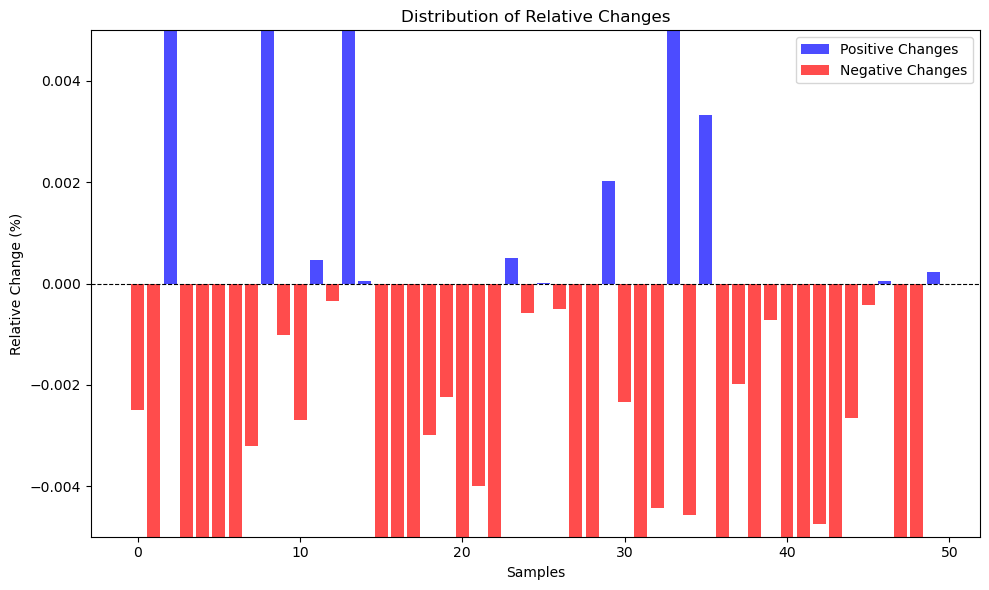

In [11]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [12]:
shap_explainer_tr_news = shap.Explainer(bert_pipeline_text_tr_news)
tr_news_bert_results = {}

for threshold in thresholds:
    
    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_bert", 
                                                            shap_explainer_tr_news,
                                                            bert_full_text_preds_tr_news, len(bert_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, bert_tokenizer_tr_news, threshold)
    
    shap_values_tr_news_short, _ = apply_shap(path_shap, top_tokens_tr_news, 
                                              f"shap_values_tr_news_short_{threshold}_bert", 
                                              shap_explainer_tr_news,
                                              bert_full_text_preds_tr_news, len(bert_label2id_tr_news),
                                              only_load=only_load)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (shap_values_tr_news, shap_values_tr_news_short, tr_news_bert_result)
    
    clear_gpu_memory()

    show(tr_news_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tr_news_0.5_bert' file shape: (50, None, 11)
'shap_values_tr_news_short_0.5_bert' file shape: (50, None, 11)


'shap_values_tr_news_0.6_bert' file shape: (50, None, 11)
'shap_values_tr_news_short_0.6_bert' file shape: (50, None, 11)


'shap_values_tr_news_0.7_bert' file shape: (50, None, 11)
'shap_values_tr_news_short_0.7_bert' file shape: (50, None, 11)


In [13]:
# sample_no = 8

# shap.plots.text(tr_news_bert_results[0.5][0][sample_no])
# shap.plots.text(tr_news_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.567
Overall Relative Change (ORC) positive changes      :  6.433 %
Overall Relative Change (ORC) negative changes      : -35.718 %


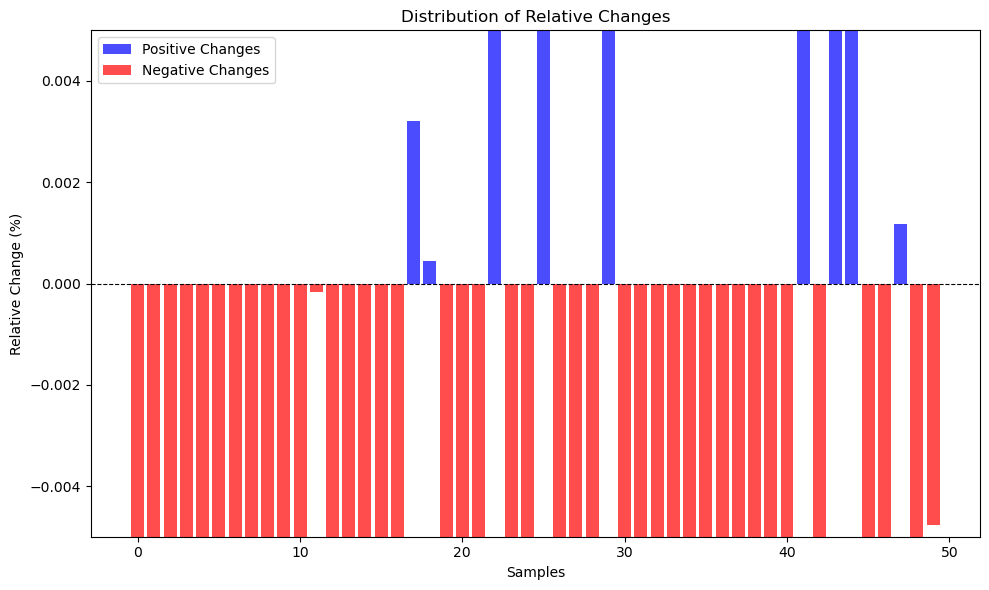


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.565
Overall Relative Change (ORC) positive changes      :  6.807 %
Overall Relative Change (ORC) negative changes      : -36.069 %


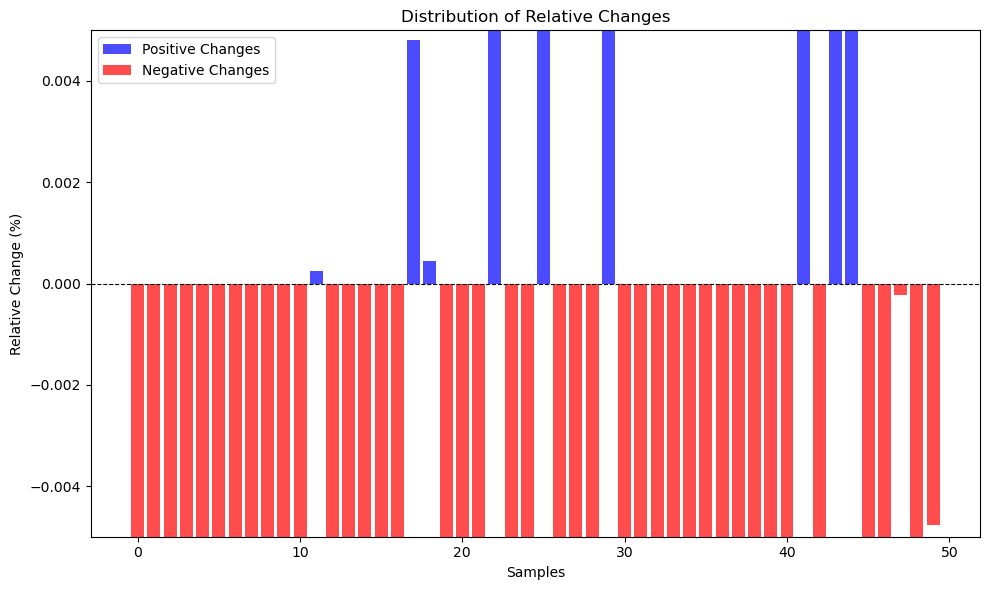


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.848
Explanations Contribution Score (ECS) of Top Tokens :  0.562
Overall Relative Change (ORC) positive changes      :  8.598 %
Overall Relative Change (ORC) negative changes      : -35.654 %


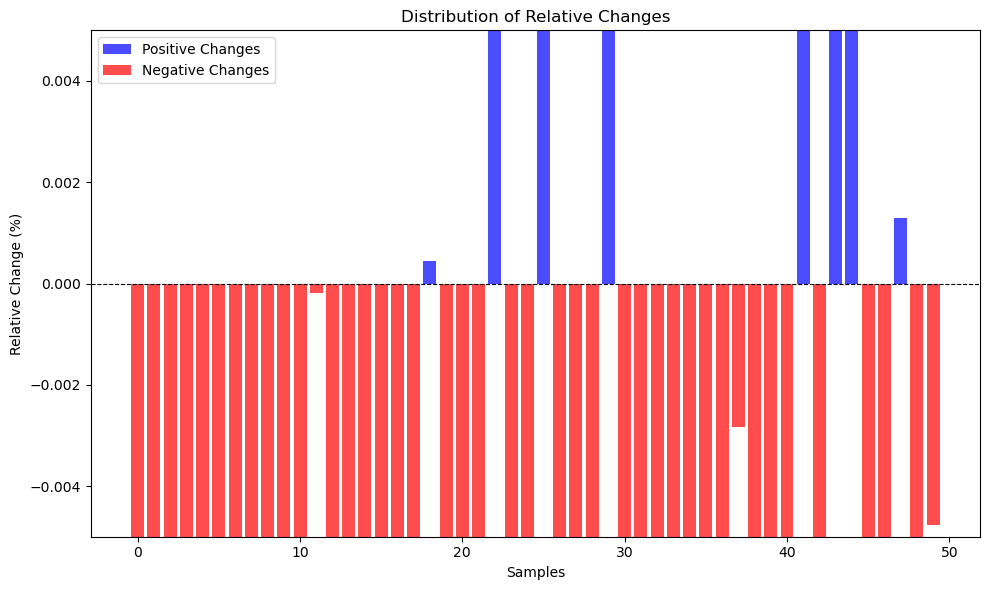

In [14]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [15]:
shap_explainer_interpress = shap.Explainer(bert_pipeline_text_interpress)
interpress_bert_results = {}

for threshold in thresholds:
    
    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_bert", 
                                                                  shap_explainer_interpress, 
                                                                  bert_full_text_preds_interpress, len(bert_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, bert_tokenizer_interpress, threshold)
    
    shap_values_interpress_short, _ = apply_shap(path_shap, top_tokens_interpress, 
                                                 f"shap_values_interpress_short_{threshold}_bert", 
                                                 shap_explainer_interpress, 
                                                 bert_full_text_preds_interpress, len(bert_label2id_interpress),
                                                 only_load=only_load)
    
    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (shap_values_interpress, shap_values_interpress_short, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_interpress_0.5_bert' file shape: (50, None, 10)
'shap_values_interpress_short_0.5_bert' file shape: (50, None, 10)


'shap_values_interpress_0.6_bert' file shape: (50, None, 10)
'shap_values_interpress_short_0.6_bert' file shape: (50, None, 10)


'shap_values_interpress_0.7_bert' file shape: (50, None, 10)
'shap_values_interpress_short_0.7_bert' file shape: (50, None, 10)


In [16]:
# sample_no = 10

# shap.plots.text(interpress_bert_results[0.5][0][sample_no])
# shap.plots.text(interpress_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.715
Overall Relative Change (ORC) positive changes      :  8.842 %
Overall Relative Change (ORC) negative changes      : -30.629 %


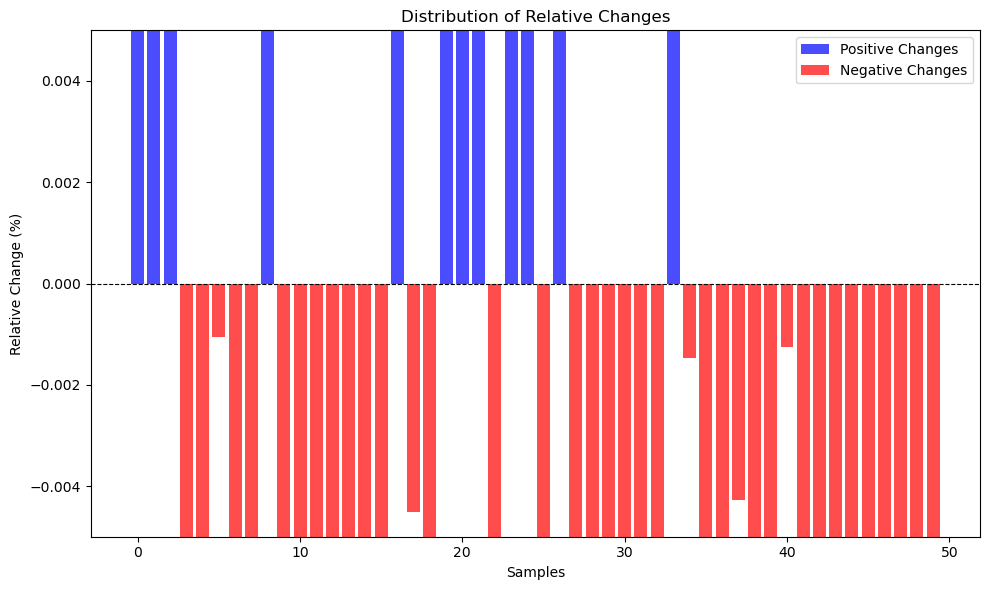


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.698
Overall Relative Change (ORC) positive changes      :  7.749 %
Overall Relative Change (ORC) negative changes      : -32.581 %


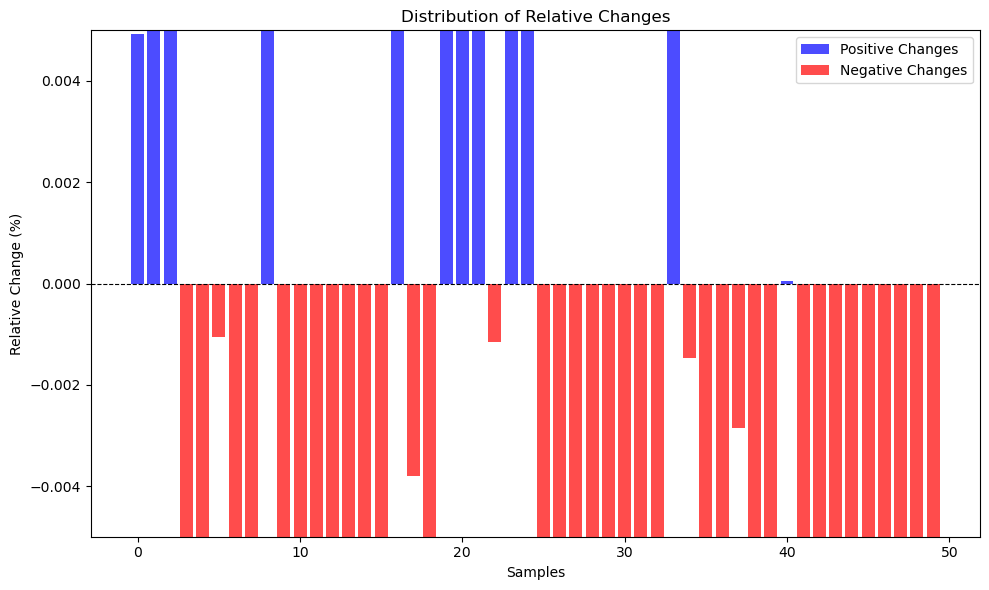


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.698
Overall Relative Change (ORC) positive changes      :  7.017 %
Overall Relative Change (ORC) negative changes      : -32.296 %


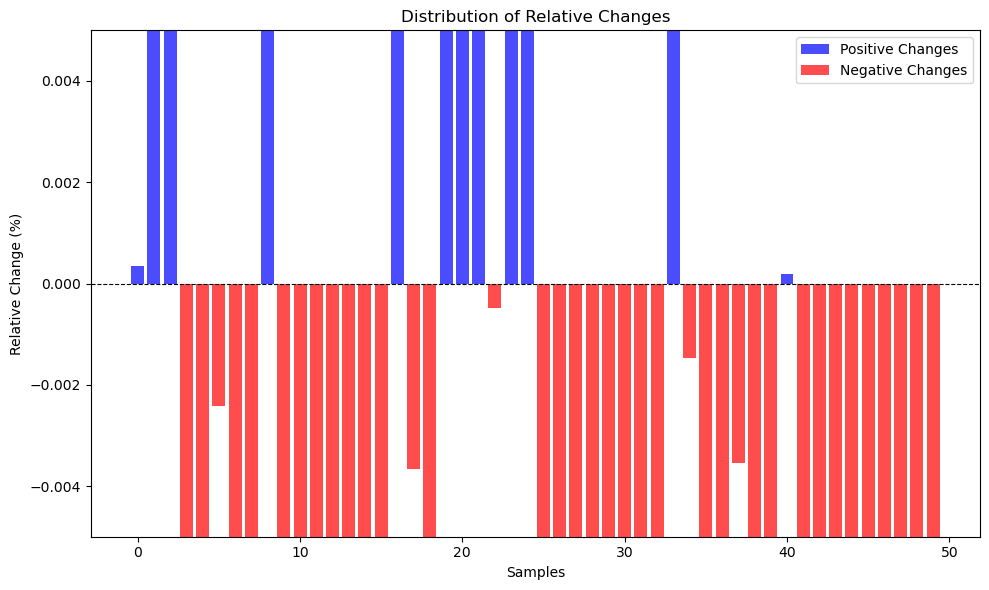

In [17]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [18]:
shap_explainer_tc32 = shap.Explainer(bert_pipeline_text_tc32)
tc32_bert_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_bert", 
                                                      shap_explainer_tc32, 
                                                      bert_full_text_preds_tc32, len(bert_label2id_tc32),
                                                      only_load=only_load)

    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, bert_tokenizer_tc32, threshold)
    
    shap_values_tc32_short, _ = apply_shap(path_shap, top_tokens_tc32, 
                                        f"shap_values_tc32_short_{threshold}_bert", 
                                        shap_explainer_tc32,
                                        bert_full_text_preds_tc32, len(bert_label2id_tc32),
                                        only_load=only_load)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (shap_values_tc32, shap_values_tc32_short, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tc32_0.5_bert' file shape: (50, None, 32)
'shap_values_tc32_short_0.5_bert' file shape: (50, None, 32)


'shap_values_tc32_0.6_bert' file shape: (50, None, 32)
'shap_values_tc32_short_0.6_bert' file shape: (50, None, 32)


'shap_values_tc32_0.7_bert' file shape: (50, None, 32)
'shap_values_tc32_short_0.7_bert' file shape: (50, None, 32)


In [19]:
# sample_no = 3

# shap.plots.text(tc32_bert_results[0.5][0][sample_no])
# shap.plots.text(tc32_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.555
Overall Relative Change (ORC) positive changes      :  10.597 %
Overall Relative Change (ORC) negative changes      : -46.056 %


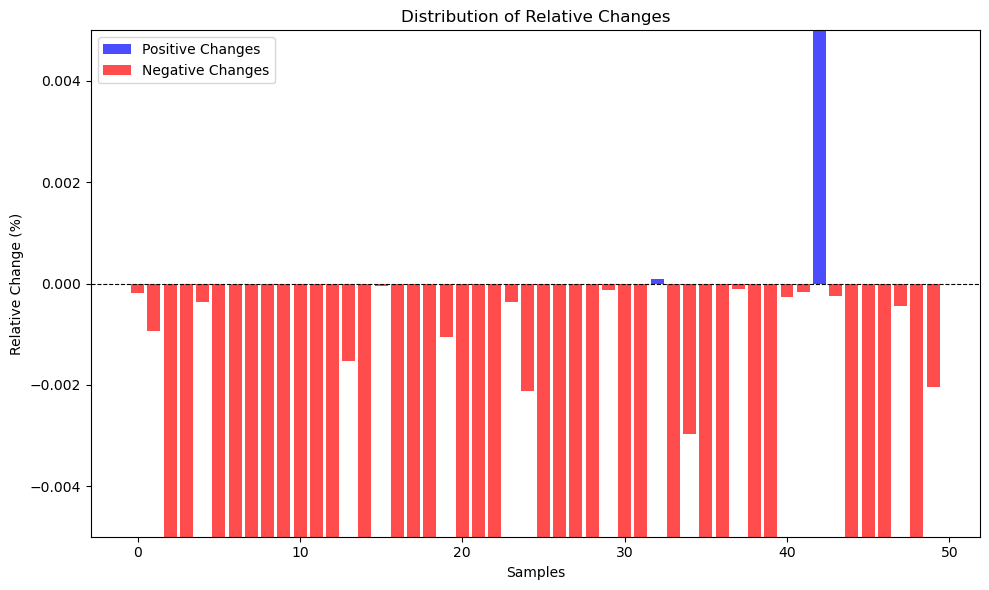


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.572
Overall Relative Change (ORC) positive changes      :  7.111 %
Overall Relative Change (ORC) negative changes      : -45.183 %


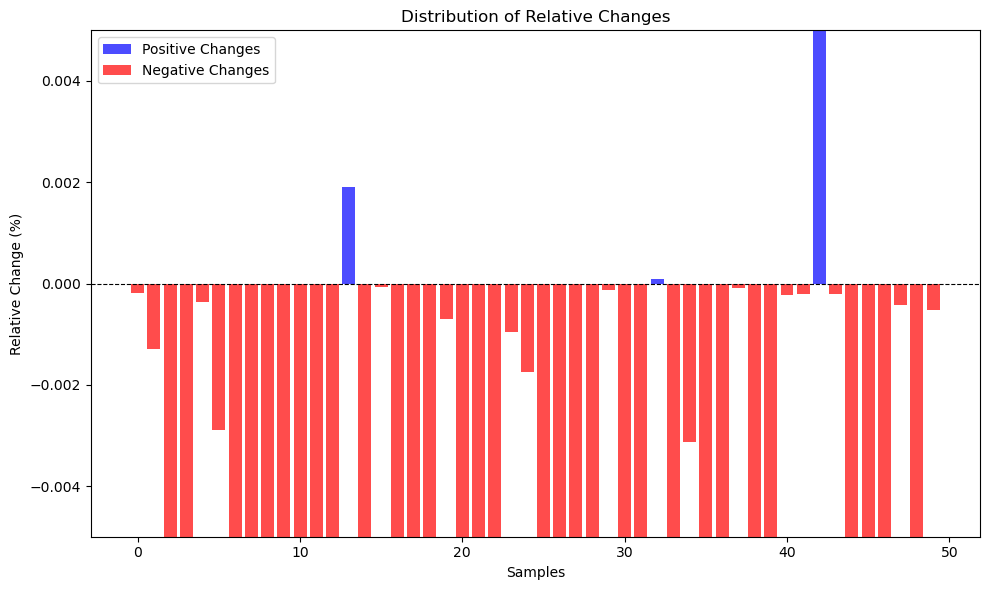


Classification accuracy                             :  0.94
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.597
Overall Relative Change (ORC) positive changes      :  7.103 %
Overall Relative Change (ORC) negative changes      : -42.587 %


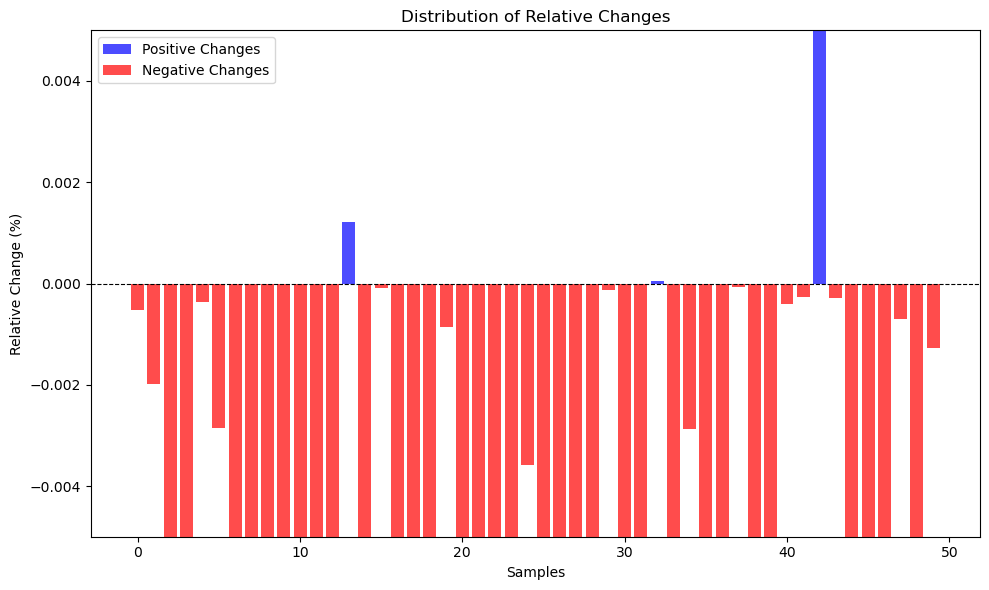

In [20]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [21]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [22]:
# predict_parameter_set_ttc4900 = {
#     'model': tbt_model_ttc4900,
#     'tokenizer': tbt_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': tbt_model_tr_news,
#     'tokenizer': tbt_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': tbt_model_interpress,
#     'tokenizer': tbt_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': tbt_model_tc32,
#     'tokenizer': tbt_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# tbt_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, tbt_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# tbt_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, tbt_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# tbt_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, tbt_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# tbt_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, tbt_label2id_tc32)

# path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

# with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tr_news, file)

# with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_interpress, file)

# with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tc32, file)

In [23]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [24]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [25]:
shap_explainer_ttc4900 = shap.Explainer(tbt_pipeline_text_ttc4900)
ttc4900_tbt_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_tbt", 
                                                    shap_explainer_ttc4900, 
                                                    tbt_full_text_preds_ttc4900, len(tbt_label2id_ttc4900),
                                                    only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, tbt_tokenizer_ttc4900, threshold)
    
    shap_values_ttc_short, _ = apply_shap(path_shap, top_tokens_ttc4900, 
                                          f"shap_values_ttc_short_{threshold}_tbt", 
                                          shap_explainer_ttc4900, 
                                          tbt_full_text_preds_ttc4900, len(tbt_label2id_ttc4900),
                                          only_load=only_load)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (shap_values_ttc, shap_values_ttc_short, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_ttc_0.5_tbt' file shape: (50, None, 7)
'shap_values_ttc_short_0.5_tbt' file shape: (50, None, 7)


'shap_values_ttc_0.6_tbt' file shape: (50, None, 7)
'shap_values_ttc_short_0.6_tbt' file shape: (50, None, 7)


'shap_values_ttc_0.7_tbt' file shape: (50, None, 7)
'shap_values_ttc_short_0.7_tbt' file shape: (50, None, 7)


In [26]:
# sample_no = 4

# shap.plots.text(ttc4900_tbt_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.86
Overall Relative Change (ORC) positive changes      :  7.621 %
Overall Relative Change (ORC) negative changes      : -19.028 %


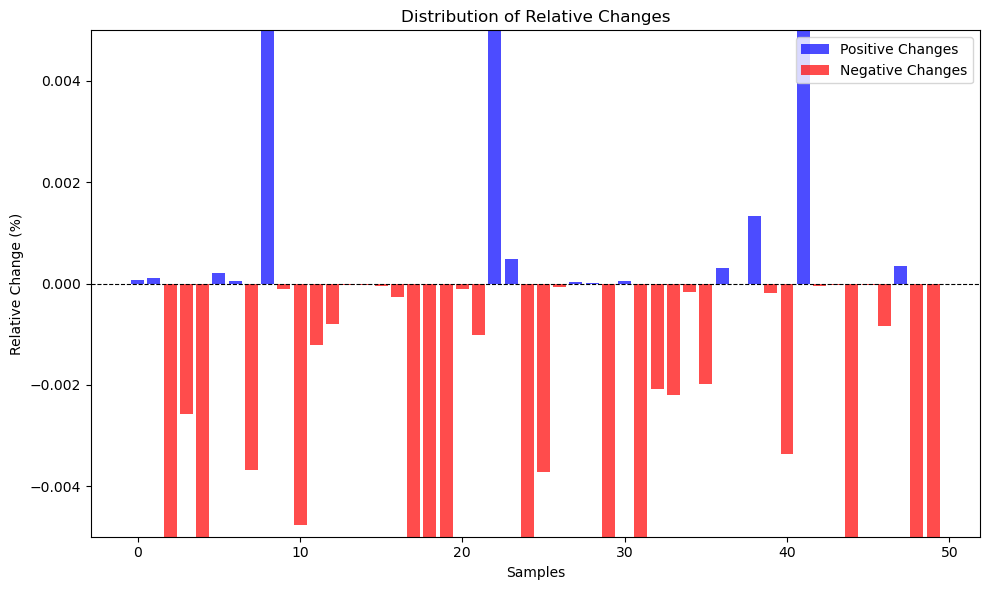


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.88
Overall Relative Change (ORC) positive changes      :  7.023 %
Overall Relative Change (ORC) negative changes      : -16.762 %


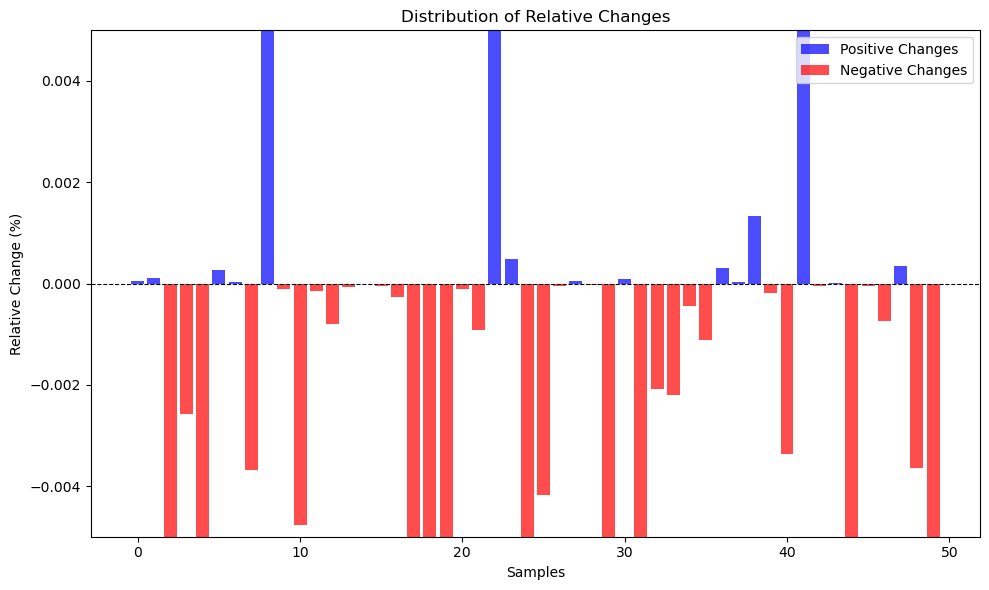


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.976
Explanations Contribution Score (ECS) of Top Tokens :  0.88
Overall Relative Change (ORC) positive changes      :  7.24 %
Overall Relative Change (ORC) negative changes      : -16.085 %


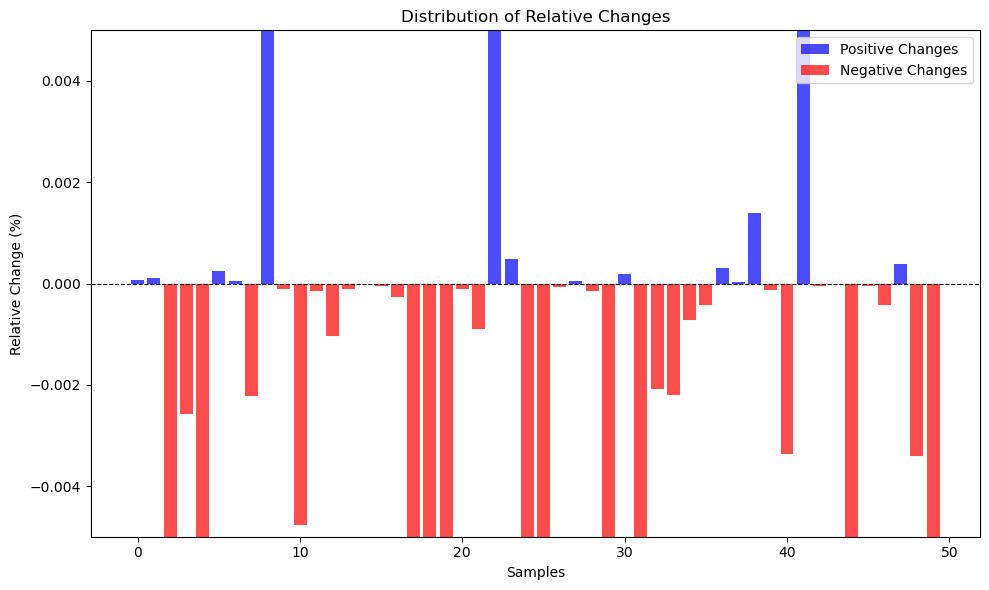

In [27]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [28]:
shap_explainer_tr_news = shap.Explainer(tbt_pipeline_text_tr_news)
tr_news_tbt_results = {}

for threshold in thresholds:

    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_tbt", 
                                                            shap_explainer_tr_news,
                                                            tbt_full_text_preds_tr_news, len(tbt_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, tbt_tokenizer_tr_news, threshold)
    
    shap_values_tr_news_short, _ = apply_shap(path_shap, top_tokens_tr_news, 
                                              f"shap_values_tr_news_short_{threshold}_tbt", 
                                              shap_explainer_tr_news, 
                                              tbt_full_text_preds_tr_news, len(tbt_label2id_tr_news),
                                              only_load=only_load)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (shap_values_tr_news, shap_values_tr_news_short, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tr_news_0.5_tbt' file shape: (50, None, 11)
'shap_values_tr_news_short_0.5_tbt' file shape: (50, None, 11)


'shap_values_tr_news_0.6_tbt' file shape: (50, None, 11)
'shap_values_tr_news_short_0.6_tbt' file shape: (50, None, 11)


'shap_values_tr_news_0.7_tbt' file shape: (50, None, 11)
'shap_values_tr_news_short_0.7_tbt' file shape: (50, None, 11)


In [29]:
# sample_no = 4

# shap.plots.text(tr_news_tbt_results[0.7][0][sample_no])
# shap.plots.text(tr_news_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.475
Overall Relative Change (ORC) positive changes      :  6.829 %
Overall Relative Change (ORC) negative changes      : -35.954 %


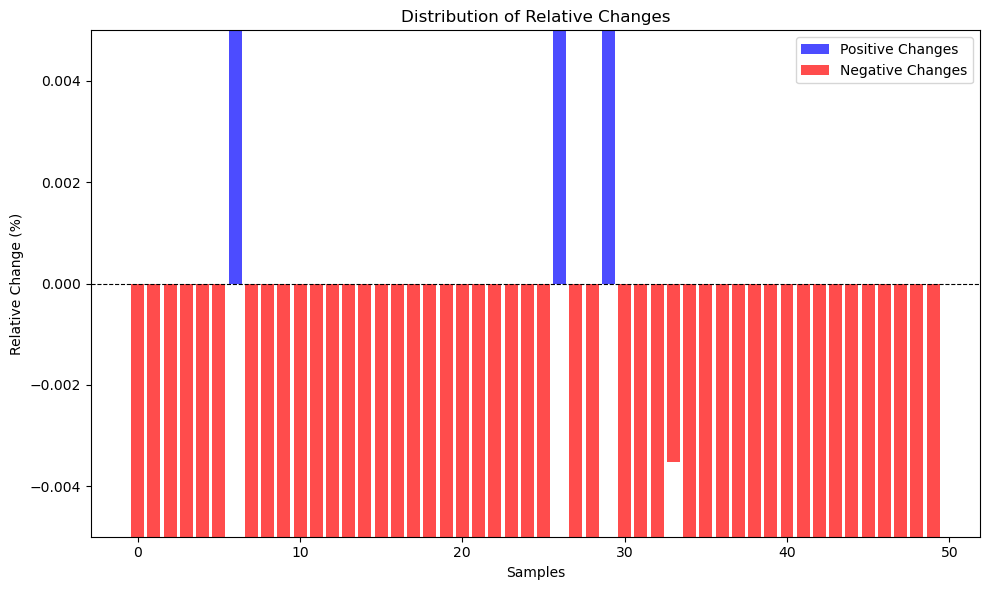


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.448
Overall Relative Change (ORC) positive changes      :  10.664 %
Overall Relative Change (ORC) negative changes      : -39.062 %


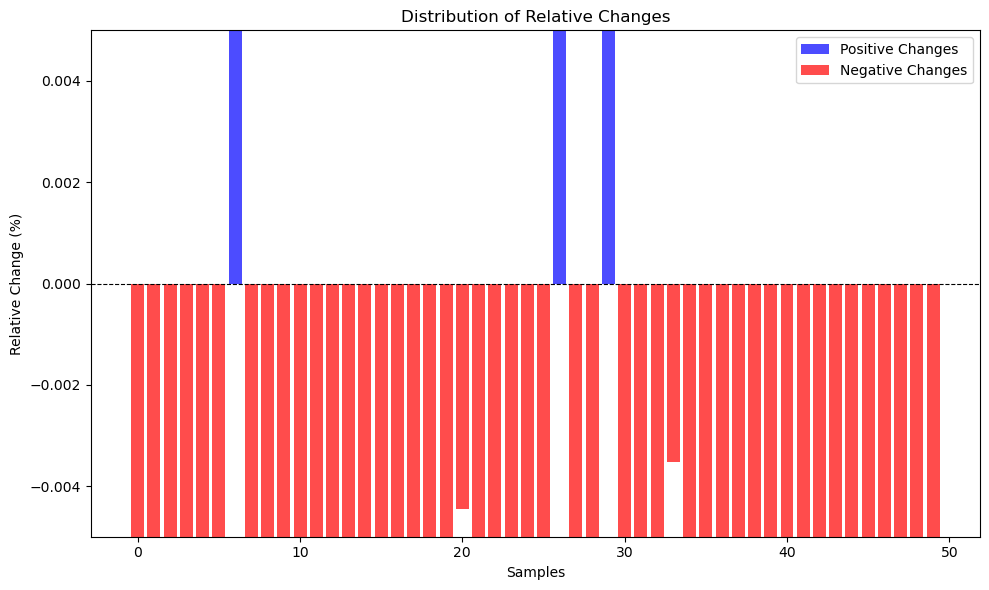


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.808
Explanations Contribution Score (ECS) of Top Tokens :  0.428
Overall Relative Change (ORC) positive changes      :  8.802 %
Overall Relative Change (ORC) negative changes      : -41.068 %


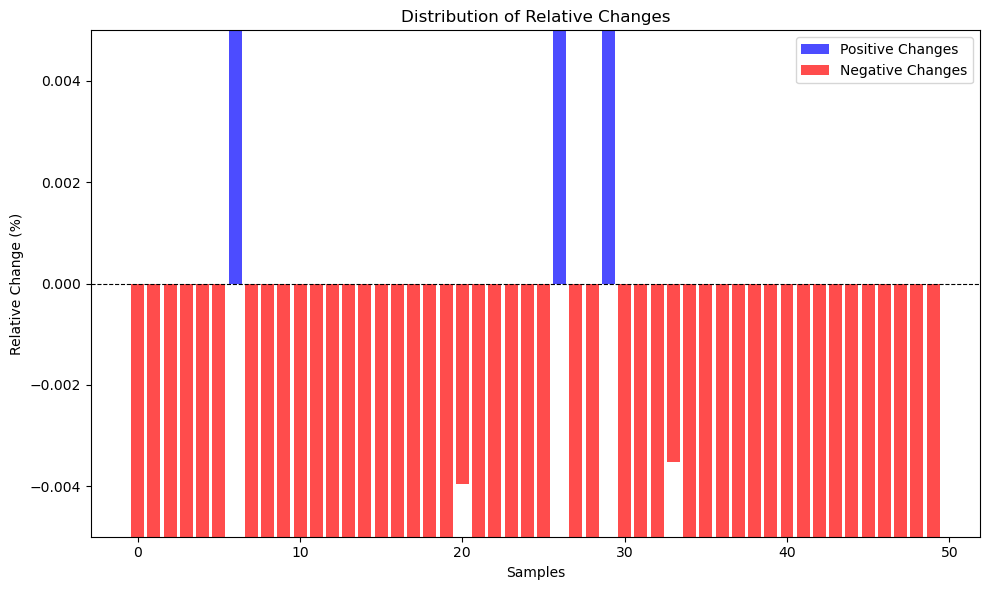

In [30]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [31]:
shap_explainer_interpress = shap.Explainer(tbt_pipeline_text_interpress)
interpress_tbt_results = {}

for threshold in thresholds:

    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_tbt", 
                                                                  shap_explainer_interpress,
                                                                  tbt_full_text_preds_interpress, len(tbt_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, tbt_tokenizer_interpress, threshold)
    
    shap_values_interpress_short, _ = apply_shap(path_shap, top_tokens_interpress, 
                                                 f"shap_values_interpress_short_{threshold}_tbt", 
                                                 shap_explainer_interpress, 
                                                 tbt_full_text_preds_interpress, len(tbt_label2id_interpress),
                                                 only_load=only_load)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (shap_values_interpress, shap_values_interpress_short, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_interpress_0.5_tbt' file shape: (50, None, 10)
'shap_values_interpress_short_0.5_tbt' file shape: (50, None, 10)


'shap_values_interpress_0.6_tbt' file shape: (50, None, 10)
'shap_values_interpress_short_0.6_tbt' file shape: (50, None, 10)


'shap_values_interpress_0.7_tbt' file shape: (50, None, 10)
'shap_values_interpress_short_0.7_tbt' file shape: (50, None, 10)


In [32]:
# sample_no = 23

# shap.plots.text(interpress_tbt_results[0.7][0][sample_no])
# shap.plots.text(interpress_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.291
Overall Relative Change (ORC) positive changes      :  22.468 %
Overall Relative Change (ORC) negative changes      : -65.857 %


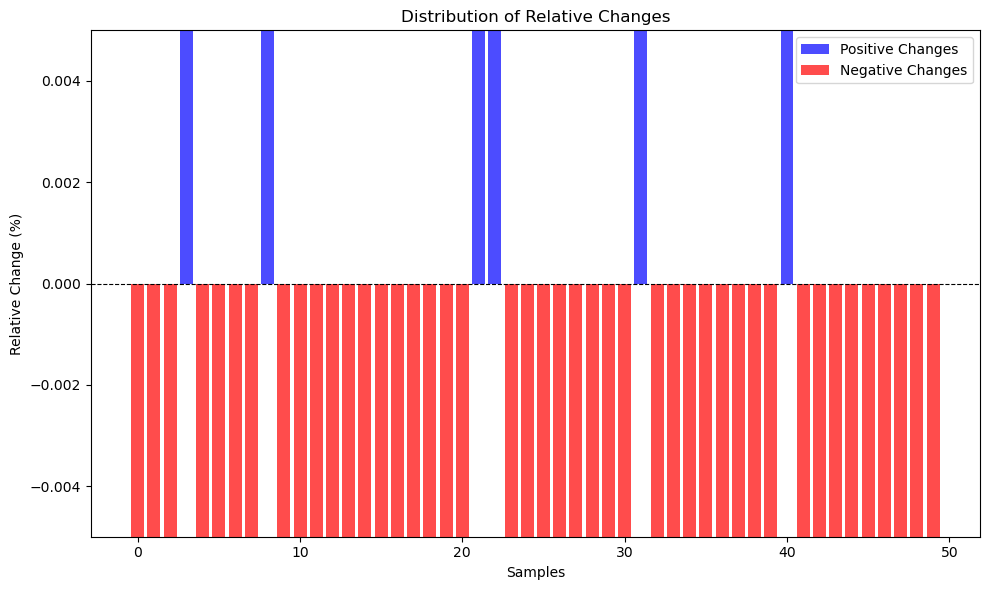


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.291
Overall Relative Change (ORC) positive changes      :  25.252 %
Overall Relative Change (ORC) negative changes      : -66.309 %


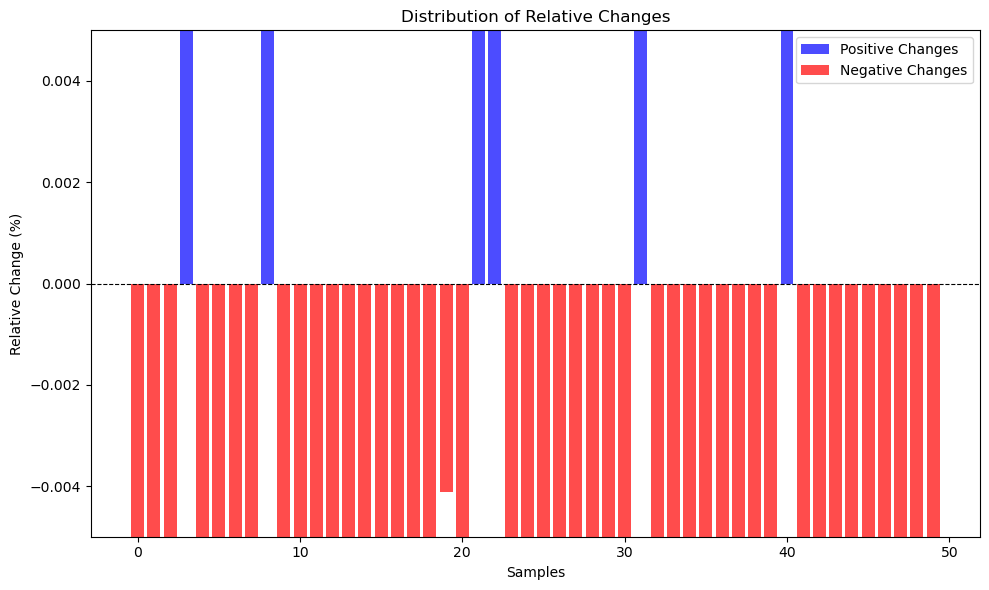


Classification accuracy                             :  0.78
Explanations Contribution Score (ECS) of Full Text  :  0.844
Explanations Contribution Score (ECS) of Top Tokens :  0.309
Overall Relative Change (ORC) positive changes      :  26.624 %
Overall Relative Change (ORC) negative changes      : -64.427 %


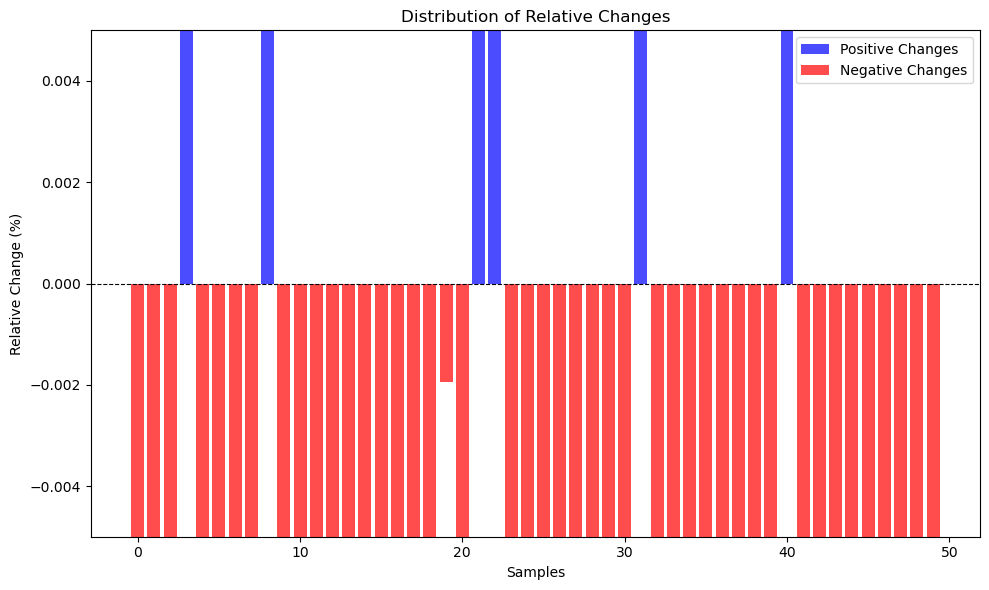

In [33]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [34]:
shap_explainer_tc32 = shap.Explainer(tbt_pipeline_text_tc32)
tc32_tbt_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_tbt", 
                                                      shap_explainer_tc32, 
                                                      tbt_full_text_preds_tc32, len(tbt_label2id_tc32),
                                                      only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, tbt_tokenizer_tc32, threshold)
    
    shap_values_tc32_short, _ = apply_shap(path_shap, top_tokens_tc32, 
                                           f"shap_values_tc32_short_{threshold}_tbt", 
                                           shap_explainer_tc32, 
                                           tbt_full_text_preds_tc32, len(tbt_label2id_tc32),
                                           only_load=only_load)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (shap_values_tc32, shap_values_tc32_short, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][2], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tc32_0.5_tbt' file shape: (50, None, 32)
'shap_values_tc32_short_0.5_tbt' file shape: (50, None, 32)


'shap_values_tc32_0.6_tbt' file shape: (50, None, 32)
'shap_values_tc32_short_0.6_tbt' file shape: (50, None, 32)


'shap_values_tc32_0.7_tbt' file shape: (50, None, 32)
'shap_values_tc32_short_0.7_tbt' file shape: (50, None, 32)


In [35]:
# sample_no = 15

# shap.plots.text(tc32_tbt_results[0.7][0][sample_no])
# shap.plots.text(tc32_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.22
Overall Relative Change (ORC) positive changes      :  0.02 %
Overall Relative Change (ORC) negative changes      : -73.647 %


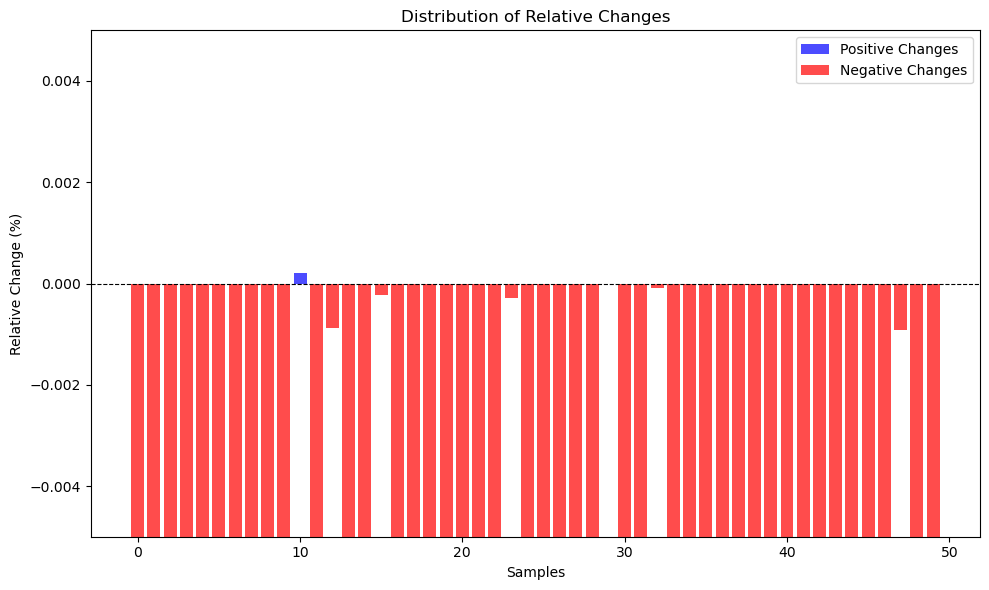


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.238
Overall Relative Change (ORC) positive changes      :  0.022 %
Overall Relative Change (ORC) negative changes      : -71.884 %


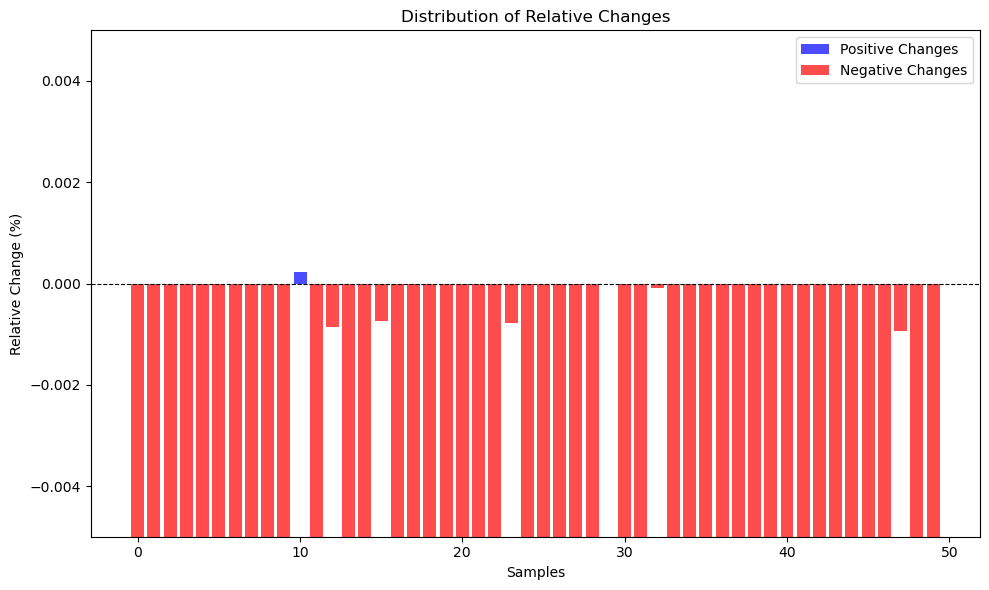


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.942
Explanations Contribution Score (ECS) of Top Tokens :  0.239
Overall Relative Change (ORC) positive changes      :  0.032 %
Overall Relative Change (ORC) negative changes      : -73.234 %


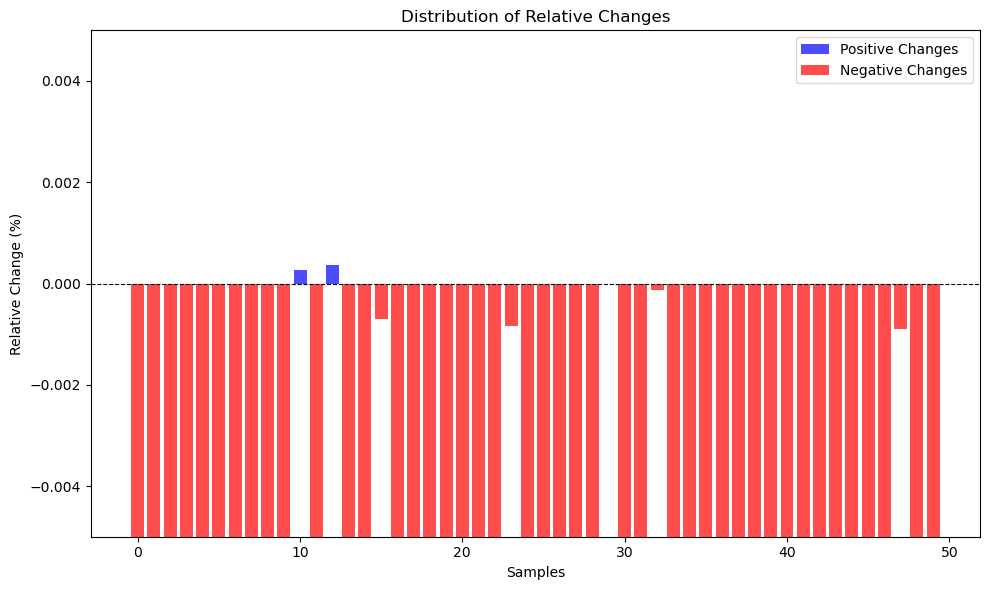

In [36]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][2])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [37]:
all_exp_results

,Cl Acc,ECS FT,ECS TT,ORC (+),ORC (-)
0,0.88,0.967,0.942,8.416,-4.970
1,0.88,0.967,0.942,6.888,-5.205
2,0.88,0.967,0.944,6.317,-5.101
3,0.78,0.848,0.567,6.433,-35.718
4,0.78,0.848,0.565,6.807,-36.069
5,0.78,0.848,0.562,8.598,-35.654
6,0.88,0.927,0.715,8.842,-30.629
7,0.88,0.927,0.698,7.749,-32.581
8,0.88,0.927,0.698,7.017,-32.296
9,0.94,0.993,0.555,10.597,-46.056


In [38]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
    all_exp_results.to_excel(writer, sheet_name='SHAP', index=False)